<a href="https://colab.research.google.com/github/schmeks/911-311_Complaints/blob/master/311_Complaint_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Reviewing 311 Complaint Data from NYC's Open Data Portal**
Becca Mason

This collab notebook takes NYPD Historic Complaint Data and Explores the content with preliminary analyses. Presents findings on the age breakdown of victims and suspects, location of complaint, and gender of victim.

# Import Data via one of two methods: API or csv 

## Complaint data from NYC Open Data via Socrata API, filtered down to Violations only

In [1]:
#installing Sodapy library and other necessary packages

# https://data.cityofnewyork.us/resource/qgea-i56i.json
!pip install sodapy

import pandas as pd
from sodapy import Socrata
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

In [26]:
# First results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("5uac-w243")

# df = pd.read_csv('https://data.cityofnewyork.us/api/views/qgea-i56i/rows.csv?accessType=DOWNLOAD')
# df.head()
# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

1000

## Alternatively, import csv to avoid throttling limits and/or slow upload speeds.

In [50]:
# Import csv
# path = "C:\Users\Rebecca\Documents\GA_Python\NYPDComplaintDataCurrentYTD.csv"
# from google.colab import files
# uploaded = files.upload()

# import io
# results_df = pd.read_csv(io.BytesIO(uploaded["C:/Users/Rebecca/Documents/GA_Python/NYPDViolationData.csv"]))
# path = open("C:/Users/Rebecca/Documents/GA_Python/NYPDComplaintDataCurrentYTD.csv")
# results_df = pd.read_csv(path)
# len(results_df)

results = pd.read_csv('https://github.com/schmeks/911-311_Complaints/blob/master/NYPDViolationData.csv')
results_df = results.copy()
print('data loaded successfully')

ParserError: ignored

# Data Manipulation: creates a dataframe and examines only violations (not emergency calls)

In [4]:
# Create a copy and make cmplnt_num the index
complaints_df = results_df.copy()
complaints_df.set_index('cmplnt_num', inplace = True)

complaints_df.head()

,addr_pct_cd,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,crm_atpt_cptd_cd,jurisdiction_code,juris_desc,ky_cd,law_cat_cd,ofns_desc,patrol_boro,pd_cd,pd_desc,prem_typ_desc,rpt_dt,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd,latitude,longitude,lat_lon,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,cmplnt_to_dt,cmplnt_to_tm,loc_of_occur_desc,parks_nm,station_name,transit_district,housing_psa,hadevelopt
cmplnt_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
314773184,48,BRONX,2019-12-31T00:00:00.000,18:00:00,COMPLETED,0.0,N.Y. POLICE DEPT,105,FELONY,ROBBERY,PATROL BORO BRONX,386.0,"ROBBERY,PERSONAL ELECTRONIC DEVICE",STREET,2019-12-31T00:00:00.000,UNKNOWN,UNKNOWN,U,45-64,WHITE HISPANIC,F,1016990,244612,40.838026269000075,-73.88168118799997,"{'latitude': '40.838026269000075', 'longitude'...",11269,35,5,43,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
289837961,25,MANHATTAN,2019-12-30T00:00:00.000,20:30:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN NORTH,338.0,"LARCENY,PETIT FROM BUILDING,UN",RESIDENCE - APT. HOUSE,2019-12-31T00:00:00.000,NaN,NaN,NaN,25-44,WHITE HISPANIC,F,999296,230862,40.800334261000046,-73.94565697199994,"{'latitude': '40.800334261000046', 'longitude'...",13093,7,4,36,16,2019-12-31T00:00:00.000,10:00:00,INSIDE,NaN,NaN,NaN,NaN,NaN
535744284,77,BROOKLYN,2019-12-24T00:00:00.000,16:55:00,COMPLETED,0.0,N.Y. POLICE DEPT,106,FELONY,FELONY ASSAULT,PATROL BORO BKLYN NORTH,109.0,"ASSAULT 2,1,UNCLASSIFIED",STREET,2019-12-31T00:00:00.000,UNKNOWN,BLACK,M,18-24,WHITE,M,1001068,183317,40.66983179600004,-73.93937555099996,"{'latitude': '40.66983179600004', 'longitude':...",17615,16,2,48,49,2019-12-24T00:00:00.000,17:00:00,NaN,NaN,NaN,NaN,NaN,NaN
895678119,52,BRONX,2019-12-30T00:00:00.000,19:32:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO BRONX,333.0,"LARCENY,PETIT FROM STORE-SHOPL",CHAIN STORE,2019-12-30T00:00:00.000,25-44,WHITE,F,UNKNOWN,UNKNOWN,D,1009690,257590,40.87367103500002,-73.90801364899994,"{'latitude': '40.87367103500002', 'longitude':...",11272,48,4,39,33,NaN,NaN,INSIDE,NaN,NaN,NaN,NaN,NaN
299841674,18,MANHATTAN,2019-12-30T00:00:00.000,15:30:00,COMPLETED,0.0,N.Y. POLICE DEPT,341,MISDEMEANOR,PETIT LARCENY,PATROL BORO MAN SOUTH,301.0,"LARCENY,PETIT BY ACQUIRING LOS",STREET,2019-12-30T00:00:00.000,NaN,NaN,NaN,25-44,WHITE HISPANIC,M,985766,216503,40.76093528000007,-73.99452906599998,"{'latitude': '40.76093528000007', 'longitude':...",13094,12,4,10,10,2019-12-30T00:00:00.000,16:50:00,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Cut down data just to law_cat_cd = VIOLATION

violations = complaints_df[complaints_df['law_cat_cd'] == "VIOLATION"].copy()
sorted_violations = violations.sort_values(by = ["rpt_dt"], ascending = False)
sorted_violations.head()

,addr_pct_cd,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,crm_atpt_cptd_cd,jurisdiction_code,juris_desc,ky_cd,law_cat_cd,ofns_desc,patrol_boro,pd_cd,pd_desc,prem_typ_desc,rpt_dt,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd,latitude,longitude,lat_lon,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,cmplnt_to_dt,cmplnt_to_tm,loc_of_occur_desc,parks_nm,station_name,transit_district,housing_psa,hadevelopt
cmplnt_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536304115,13,MANHATTAN,2019-12-28T00:00:00.000,15:05:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO MAN SOUTH,637.0,"HARASSMENT,SUBD 1,CIVILIAN",RESIDENCE - APT. HOUSE,2019-12-28T00:00:00.000,65+,WHITE,F,18-24,ASIAN / PACIFIC ISLANDER,F,985850,210155,40.74351160900005,-73.99422735499998,"{'latitude': '40.74351160900005', 'longitude':...",12074,12,4,10,7,2019-12-28T00:00:00.000,15:10:00,INSIDE,NaN,NaN,NaN,NaN,NaN
355744896,46,BRONX,2019-12-28T00:00:00.000,14:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,2019-12-28T00:00:00.000,UNKNOWN,BLACK,M,25-44,BLACK HISPANIC,F,1011301,252369,40.85933619200006,-73.90220955699994,"{'latitude': '40.85933619200006', 'longitude':...",11606,6,5,29,29,2019-12-28T00:00:00.000,14:23:00,INSIDE,NaN,NaN,NaN,NaN,NaN
271699374,41,BRONX,2019-12-25T00:00:00.000,11:20:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",STREET,2019-12-25T00:00:00.000,65+,WHITE HISPANIC,M,45-64,WHITE HISPANIC,F,1015387,237462,40.818407371000035,-73.88750750299994,"{'latitude': '40.818407371000035', 'longitude'...",12343,8,5,43,24,NaN,NaN,INSIDE,NaN,NaN,NaN,NaN,NaN
708944208,20,MANHATTAN,2019-12-24T00:00:00.000,14:45:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO MAN NORTH,638.0,"HARASSMENT,SUBD 3,4,5",STREET,2019-12-24T00:00:00.000,NaN,NaN,NaN,45-64,WHITE,M,989197,222103,40.77630457400005,-73.98213988499998,"{'latitude': '40.77630457400005', 'longitude':...",12420,20,4,19,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
220063575,68,BROOKLYN,2019-12-22T00:00:00.000,22:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BKLYN SOUTH,638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,2019-12-22T00:00:00.000,45-64,BLACK,M,UNKNOWN,UNKNOWN,M,975432,167102,40.625336705000045,-74.03176756699997,"{'latitude': '40.625336705000045', 'longitude'...",17216,10,2,44,41,NaN,NaN,INSIDE,NaN,NaN,NaN,NaN,NaN


# Data Analysis: Tables

In [6]:
# See date breakdown of data
print(min(violations.rpt_dt))
print(max(violations.rpt_dt))

2019-04-21T00:00:00.000
2019-12-28T00:00:00.000


Now, learn more about the characteristics of the complaints, including victim characteristics and suspect characteristics.

In [7]:
# understand the data counts and data types for the columns
violations.info()

<class 'pandas.core.frame.DataFrame'>
Index: 177 entries, 536304115 to 566709190
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   addr_pct_cd                  177 non-null    object
 1   boro_nm                      177 non-null    object
 2   cmplnt_fr_dt                 177 non-null    object
 3   cmplnt_fr_tm                 177 non-null    object
 4   crm_atpt_cptd_cd             177 non-null    object
 5   jurisdiction_code            177 non-null    object
 6   juris_desc                   177 non-null    object
 7   ky_cd                        177 non-null    object
 8   law_cat_cd                   177 non-null    object
 9   ofns_desc                    177 non-null    object
 10  patrol_boro                  177 non-null    object
 11  pd_cd                        177 non-null    object
 12  pd_desc                      177 non-null    object
 13  prem_typ_desc             

In [8]:
# Check against total number of violations
violations["ofns_desc"].value_counts()

HARRASSMENT 2    177
Name: ofns_desc, dtype: int64

In [9]:
# Count by types of violation
violations["pd_desc"].value_counts()

HARASSMENT,SUBD 3,4,5         142
HARASSMENT,SUBD 1,CIVILIAN     35
Name: pd_desc, dtype: int64

In [10]:
# Create new variable called "rept_dt_yr" that only contains the year the complaint was made
import datetime

violations["rpt_dt_yr"] = pd.DatetimeIndex(violations["rpt_dt"]).year
violations.head()

,addr_pct_cd,boro_nm,cmplnt_fr_dt,cmplnt_fr_tm,crm_atpt_cptd_cd,jurisdiction_code,juris_desc,ky_cd,law_cat_cd,ofns_desc,patrol_boro,pd_cd,pd_desc,prem_typ_desc,rpt_dt,susp_age_group,susp_race,susp_sex,vic_age_group,vic_race,vic_sex,x_coord_cd,y_coord_cd,latitude,longitude,lat_lon,:@computed_region_efsh_h5xi,:@computed_region_f5dn_yrer,:@computed_region_yeji_bk3q,:@computed_region_92fq_4b7q,:@computed_region_sbqj_enih,cmplnt_to_dt,cmplnt_to_tm,loc_of_occur_desc,parks_nm,station_name,transit_district,housing_psa,hadevelopt,rpt_dt_yr
cmplnt_num,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536304115,13,MANHATTAN,2019-12-28T00:00:00.000,15:05:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO MAN SOUTH,637.0,"HARASSMENT,SUBD 1,CIVILIAN",RESIDENCE - APT. HOUSE,2019-12-28T00:00:00.000,65+,WHITE,F,18-24,ASIAN / PACIFIC ISLANDER,F,985850,210155,40.74351160900005,-73.99422735499998,"{'latitude': '40.74351160900005', 'longitude':...",12074,12,4,10,7,2019-12-28T00:00:00.000,15:10:00,INSIDE,NaN,NaN,NaN,NaN,NaN,2019
355744896,46,BRONX,2019-12-28T00:00:00.000,14:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,2019-12-28T00:00:00.000,UNKNOWN,BLACK,M,25-44,BLACK HISPANIC,F,1011301,252369,40.85933619200006,-73.90220955699994,"{'latitude': '40.85933619200006', 'longitude':...",11606,6,5,29,29,2019-12-28T00:00:00.000,14:23:00,INSIDE,NaN,NaN,NaN,NaN,NaN,2019
271699374,41,BRONX,2019-12-25T00:00:00.000,11:20:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BRONX,638.0,"HARASSMENT,SUBD 3,4,5",STREET,2019-12-25T00:00:00.000,65+,WHITE HISPANIC,M,45-64,WHITE HISPANIC,F,1015387,237462,40.818407371000035,-73.88750750299994,"{'latitude': '40.818407371000035', 'longitude'...",12343,8,5,43,24,NaN,NaN,INSIDE,NaN,NaN,NaN,NaN,NaN,2019
708944208,20,MANHATTAN,2019-12-24T00:00:00.000,14:45:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO MAN NORTH,638.0,"HARASSMENT,SUBD 3,4,5",STREET,2019-12-24T00:00:00.000,NaN,NaN,NaN,45-64,WHITE,M,989197,222103,40.77630457400005,-73.98213988499998,"{'latitude': '40.77630457400005', 'longitude':...",12420,20,4,19,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019
220063575,68,BROOKLYN,2019-12-22T00:00:00.000,22:10:00,COMPLETED,0.0,N.Y. POLICE DEPT,578,VIOLATION,HARRASSMENT 2,PATROL BORO BKLYN SOUTH,638.0,"HARASSMENT,SUBD 3,4,5",RESIDENCE - APT. HOUSE,2019-12-22T00:00:00.000,45-64,BLACK,M,UNKNOWN,UNKNOWN,M,975432,167102,40.625336705000045,-74.03176756699997,"{'latitude': '40.625336705000045', 'longitude'...",17216,10,2,44,41,NaN,NaN,INSIDE,NaN,NaN,NaN,NaN,NaN,2019


In [11]:
#Breaking down complaint counts by victim age, race, and sex

violations.groupby(["vic_age_group", "vic_race", "vic_sex"]).size()

vic_age_group  vic_race                  vic_sex
18-24          ASIAN / PACIFIC ISLANDER  F           1
               BLACK                     F          10
                                         M           1
               UNKNOWN                   F           2
                                         M           3
               WHITE                     F           4
                                         M           1
               WHITE HISPANIC            F           1
25-44          BLACK                     F          30
                                         M          15
               BLACK HISPANIC            F           1
                                         M           1
               UNKNOWN                   F           5
                                         M           2
               WHITE                     F           5
                                         M           9
               WHITE HISPANIC            F           5
                

In [12]:
#Breaking down complaint counts by suspect age, race, and sex

violations_sus = violations.groupby(["susp_age_group", "susp_race", "susp_sex"]).size()
violations_sus

susp_age_group  susp_race       susp_sex
18-24           BLACK           F            4
                                M            4
                                U            1
                UNKNOWN         M            1
                WHITE HISPANIC  M            2
25-44           BLACK           F           11
                                M           20
                                U            1
                BLACK HISPANIC  F            1
                                M            2
                UNKNOWN         M            6
                WHITE           F            3
                                M            5
                                U            1
                WHITE HISPANIC  M            3
45-64           BLACK           F            2
                                M            4
                BLACK HISPANIC  M            1
                UNKNOWN         F            1
                                M            1
                WHI

# Visualize Suspects by Age: determine additional insights

In [0]:
import seaborn as sns

cmplnt_num
536304115        65+
355744896    UNKNOWN
271699374        65+
708944208        NaN
220063575      45-64
              ...   
764178590        NaN
911964758    UNKNOWN
499472710      25-44
669659878      25-44
566709190    UNKNOWN
Name: susp_age_group, Length: 177, dtype: object


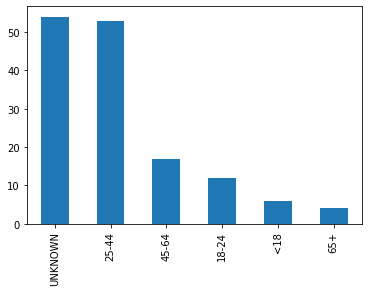

In [14]:
# Graph count plot by suspect age

susp_age = violations["susp_age_group"]
print(susp_age)

violations["susp_age_group"].value_counts().plot(kind='bar')

cmplnt_num
536304115      18-24
355744896      25-44
271699374      45-64
708944208      45-64
220063575    UNKNOWN
              ...   
764178590      45-64
911964758      25-44
499472710      45-64
669659878      25-44
566709190      25-44
Name: vic_age_group, Length: 177, dtype: object


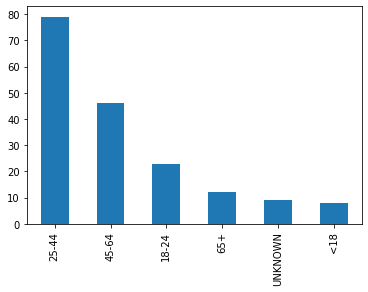

In [15]:
# Graph count plot by victim age

vic_age = violations["vic_age_group"]
print(vic_age)

violations["vic_age_group"].value_counts().plot(kind='bar')

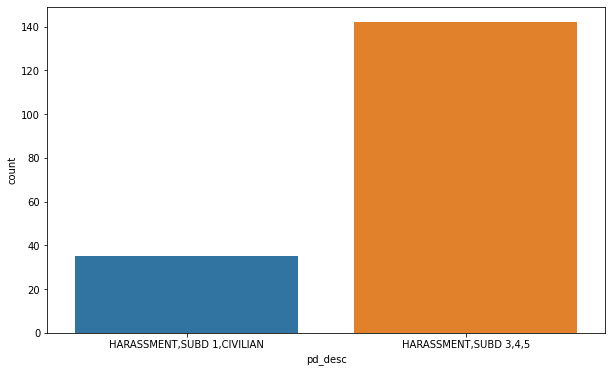

In [16]:
# Plot counts by type of description of internal classification corresponding 
# with PD code (more granular than Offense Description), updated figure size to 
# allow better readability of x axis labels

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='pd_desc', ax = ax, data=violations)

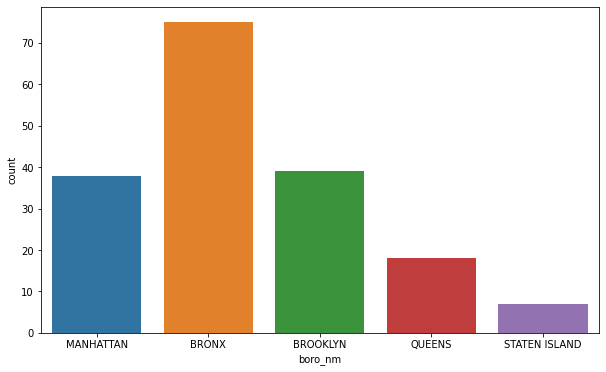

In [17]:
# Plot counts by Borough in which they occurred, updated figure size to allow better readability of x axis labels

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='boro_nm', ax = ax, data=violations)

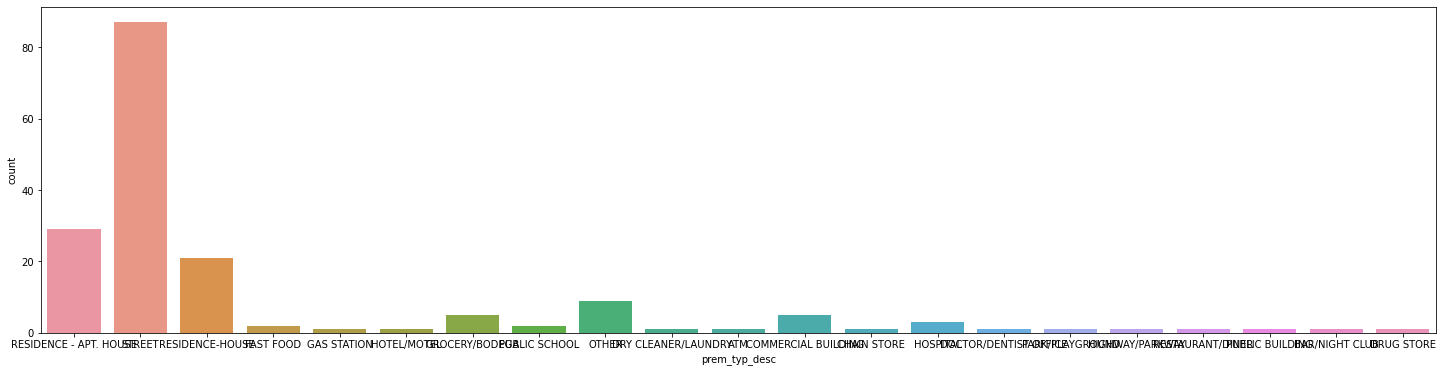

In [18]:
# Plot counts by location in which they occurred, updated figure size to allow better readability of x axis labels

fig_dims = (25, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x='prem_typ_desc', ax = ax, data=violations)

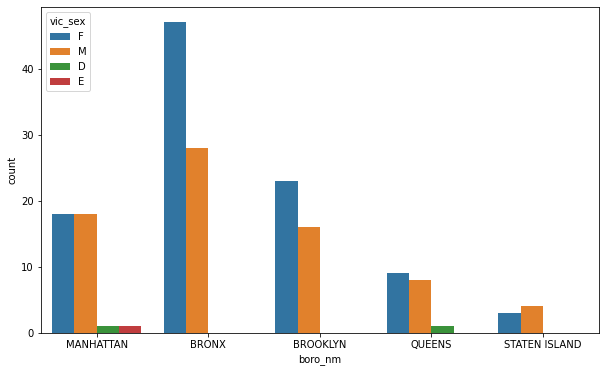

In [19]:
# Are there gender differences in victim sex across borough?

# Yes, there is a much wider gap between women and men reporting complaints in the Bronx than in other Boroughs.

fig_dims = (10, 6)
fig, ax = plt.subplots(figsize=fig_dims)

sns.countplot(x='boro_nm', hue = 'vic_sex', data=violations)

# For another day: Mapping Complaints

In [20]:
import descartes
!pip install geopandas
from shapely.geometry import Point 
!pip install cartopy
%matplotlib inline

     |████████████████████████████████| 931kB 3.3MB/s 
     |████████████████████████████████| 14.7MB 272kB/s 
     |████████████████████████████████| 10.4MB 46.7MB/s 
     |████████████████████████████████| 8.9MB 3.4MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 /usr/local/lib/python3.6/dist-packages/pip/_vendor/pep517/_in_process.py get_requires_for_build_wheel /tmp/tmpk86n5aw5 Check the logs for full command output.


In [21]:
# Setting Bounding Box for XY Coords
BBox = (violations.longitude.min(), violations.longitude.max(), violations.latitude.min(), violations.latitude.max())
BBox

('-73.73150635799993',
 '-74.23410772899997',
 '40.51728641000005',
 '40.899666704000026')

In [0]:
# Sadly the image from BBox was too large to download from open street map.
# Tried another method below that also resulted in difficulty.

# import cartopy.crs as ccrs

# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.coastlines()

# plt.show()

In [0]:
# Plot complaints

# fig, ax = plt.subplots(figsize = (8,7))
# ax.scatter(violations.longitude, violations.latitude, zorder=1, alpha= 0.2, c='b', s=10)
# ax.set_title('Complaints in NYC')
# ax.set_xlim(BBox[0],BBox[1])
# ax.set_ylim(BBox[2],BBox[3])
# ax.imshow(ruh_m, zorder=0, extent = BBox, aspect= 'equal')